In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Install necessary libraries
!pip install torch torchvision timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 11.1 MB/s eta 0:00:00


In [87]:
# Import libraries
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from torchsummary import summary
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
from sklearn.metrics import f1_score
from timm import create_model
from torch.cuda.amp import autocast, GradScaler
from torch.optim.lr_scheduler import StepLR

# Confusion Matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [150]:
# Define constants
data_dir = '/content/drive/MyDrive'  # Replace with the actual path
batch_size = 32
learning_rate = 0.0001
epochs = 12
fine_tune_epochs = 6
image_size = (112, 112)  # Change this to the desired size

In [151]:
# Define data transformations with increased augmentation
transform = transforms.Compose([
    transforms.RandomResizedCrop(image_size, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(30),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor(),
])

In [152]:
# Load dataset
train_dataset = datasets.ImageFolder(root=data_dir + '/train', transform=transform)
test_dataset = datasets.ImageFolder(root=data_dir + '/test', transform=transform)

In [153]:
# Split the dataset into training and validation sets
validation_split = 0.2
dataset_size = len(train_dataset)
split = int(np.floor(validation_split * dataset_size))
indices = list(range(dataset_size))
np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

# Create data loaders for training and validation sets
train_sampler = torch.utils.data.sampler.SubsetRandomSampler(train_indices)
val_sampler = torch.utils.data.sampler.SubsetRandomSampler(val_indices)

train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler)
val_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=val_sampler)

In [154]:
# Create data loaders
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [155]:
# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [156]:
# Define MobileNetV3 model
num_classes = 3
model = create_model('mobilenetv3_large_100', pretrained=True, num_classes=num_classes)
model.to(device)

MobileNetV3(
  (conv_stem): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): BatchNormAct2d(
    16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
    (drop): Identity()
    (act): Hardswish()
  )
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
        (bn1): BatchNormAct2d(
          16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): ReLU(inplace=True)
        )
        (se): Identity()
        (conv_pw): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2): BatchNormAct2d(
          16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): Identity()
        )
        (drop_path): Identity()
      )
    )
    (1): Sequential(
      (0): InvertedResidual(
 

In [157]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [158]:
# Define learning rate scheduler
scheduler = StepLR(optimizer, step_size=2, gamma=0.5)

In [159]:
# Lists to store training statistics
train_loss_history = []
accuracy_history = []

# Lists to store training and validation statistics
val_loss_history = []
val_accuracy_history = []

In [160]:
# Function to register hooks for feature extraction
def register_hooks(model):
    activations = []

    def hook_fn(module, input, output):
        activations.append(output)

    hooks = []
    for layer in model.children():
        if isinstance(layer, nn.Conv2d):
            hook = layer.register_forward_hook(hook_fn)
            hooks.append(hook)

    return activations, hooks

In [161]:
# Extract activations and register hooks
activations, hooks = register_hooks(model)
scaler = GradScaler()

In [162]:
# Training loop with mixed precision and LR scheduling
for epoch in range(epochs):
    # Training loop
    model.train()
    train_loss, correct_predictions, total_samples = 0.0, 0, 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        with autocast():
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        train_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct_predictions += (preds == labels).sum().item()
        total_samples += labels.size(0)

    # Validation loop
    model.eval()
    val_loss, val_correct_predictions, val_total_samples = 0.0, 0, 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            val_correct_predictions += (preds == labels).sum().item()
            val_total_samples += labels.size(0)

    # Update learning rate
    scheduler.step()

    # Calculate and print training metrics
    accuracy = correct_predictions / total_samples
    print(f'Epoch {epoch + 1}/{epochs}, LR: {scheduler.get_lr()[0]}, Train Loss: {train_loss/len(train_loader)}, Accuracy: {accuracy}')

    # Calculate and print validation metrics
    val_accuracy = val_correct_predictions / val_total_samples
    print(f'Epoch {epoch + 1}/{epochs}, Val Loss: {val_loss/len(val_loader)}, Val Accuracy: {val_accuracy}')

    # Append metrics to history
    train_loss_history.append(train_loss/len(train_loader))
    accuracy_history.append(accuracy)
    val_accuracy_history.append(val_accuracy)

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:384: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


Epoch 1/12, LR: 0.0001, Train Loss: 3.2039911140475357, Accuracy: 0.4251234229292375
Epoch 1/12, Val Loss: 2.8282123883565267, Val Accuracy: 0.43956043956043955
Epoch 2/12, LR: 2.5e-05, Train Loss: 2.432062682352568, Accuracy: 0.5002742731760834
Epoch 2/12, Val Loss: 2.0825994431972505, Val Accuracy: 0.512087912087912
Epoch 3/12, LR: 5e-05, Train Loss: 2.087578999368768, Accuracy: 0.526055951727921
Epoch 3/12, Val Loss: 2.0155703981717425, Val Accuracy: 0.47692307692307695
Epoch 4/12, LR: 1.25e-05, Train Loss: 2.04093599319458, Accuracy: 0.5293472298409215
Epoch 4/12, Val Loss: 1.974154031276703, Val Accuracy: 0.4989010989010989
Epoch 5/12, LR: 2.5e-05, Train Loss: 1.8736072130370558, Accuracy: 0.5419637959407569
Epoch 5/12, Val Loss: 2.0522417028745017, Val Accuracy: 0.5142857142857142
Epoch 6/12, LR: 6.25e-06, Train Loss: 1.8022410430406268, Accuracy: 0.5529347229840922
Epoch 6/12, Val Loss: 1.8703011433283487, Val Accuracy: 0.5318681318681319
Epoch 7/12, LR: 1.25e-05, Train Loss: 1.

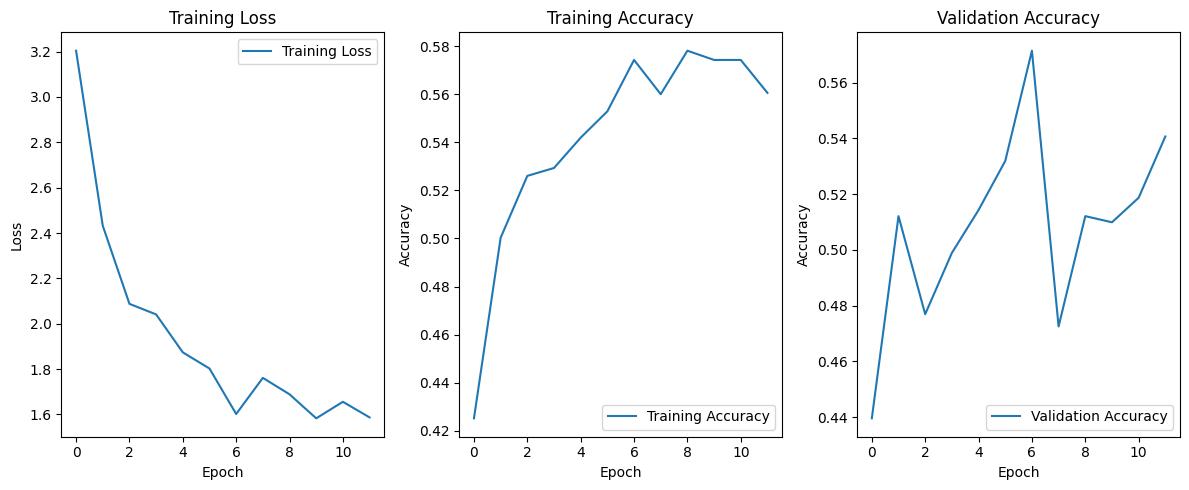

In [163]:
# Plot training loss, accuracy, and validation accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 3, 1)
plt.plot(train_loss_history, label='Training Loss')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(accuracy_history, label='Training Accuracy')
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(val_accuracy_history, label='Validation Accuracy')
plt.title('Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [164]:
# Print summary
print("\nTraining Summary:")
print(f"Final Training Loss: {train_loss_history[-1]}")
print(f"Final Training Accuracy: {accuracy_history[-1]}")

print("\nValidation Summary:")
print(f"Final Validation Accuracy: {val_accuracy_history[-1]}")


Training Summary:
Final Training Loss: 1.5866704834134955
Final Training Accuracy: 0.5606143719144268

Validation Summary:
Final Validation Accuracy: 0.5406593406593406


In [165]:
# Remove hooks
for hook in hooks:
    hook.remove()

In [166]:
# Fine-tuning loop
fine_tune_train_loss_history = []
fine_tune_accuracy_history = []
fine_tune_val_accuracy_history = []

In [167]:
# Unfreeze certain layers for fine-tuning
for param in model.parameters():
    param.requires_grad = True

In [168]:
# Decrease the learning rate for fine-tuning
fine_tune_optimizer = optim.Adam(model.parameters(), lr=learning_rate / 10)

In [169]:
# Fine-tuning loop with validation
for epoch in range(fine_tune_epochs):
    # Training loop
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        with autocast():
            fine_tune_optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(fine_tune_optimizer)
        scaler.update()

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct_predictions += (preds == labels).sum().item()
        total_samples += labels.size(0)

    # Validation loop
    model.eval()
    val_loss, val_correct_predictions, val_total_samples = 0.0, 0, 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            val_correct_predictions += (preds == labels).sum().item()
            val_total_samples += labels.size(0)

    # Calculate and print training metrics
    accuracy = correct_predictions / total_samples
    print(f'Fine-tune Epoch {epoch + 1}/{fine_tune_epochs}, Train Loss: {running_loss/len(train_loader)}, Accuracy: {accuracy}')

    # Calculate and print validation metrics
    val_accuracy = val_correct_predictions / val_total_samples
    print(f'Fine-tune Epoch {epoch + 1}/{fine_tune_epochs}, Val Loss: {val_loss/len(val_loader)}, Val Accuracy: {val_accuracy}')

    # Append metrics to history
    fine_tune_accuracy_history.append(accuracy)
    fine_tune_train_loss_history.append(running_loss/len(train_loader))
    fine_tune_val_accuracy_history.append(val_accuracy)


Fine-tune Epoch 1/6, Train Loss: 1.6305534588663202, Accuracy: 0.5682940208447613
Fine-tune Epoch 1/6, Val Loss: 1.837524708112081, Val Accuracy: 0.5164835164835165
Fine-tune Epoch 2/6, Train Loss: 1.6000745380133914, Accuracy: 0.5688425671969282
Fine-tune Epoch 2/6, Val Loss: 1.9874885479609172, Val Accuracy: 0.5406593406593406
Fine-tune Epoch 3/6, Train Loss: 1.5754639234459191, Accuracy: 0.5842018650575974
Fine-tune Epoch 3/6, Val Loss: 1.7412717501322428, Val Accuracy: 0.545054945054945
Fine-tune Epoch 4/6, Train Loss: 1.5177345066739802, Accuracy: 0.5677454744925946
Fine-tune Epoch 4/6, Val Loss: 1.9390520016352335, Val Accuracy: 0.5010989010989011
Fine-tune Epoch 5/6, Train Loss: 1.5982994165336877, Accuracy: 0.5710367526055952
Fine-tune Epoch 5/6, Val Loss: 1.6586816986401876, Val Accuracy: 0.5604395604395604
Fine-tune Epoch 6/6, Train Loss: 1.5005755215360408, Accuracy: 0.5842018650575974
Fine-tune Epoch 6/6, Val Loss: 1.7602324783802032, Val Accuracy: 0.545054945054945


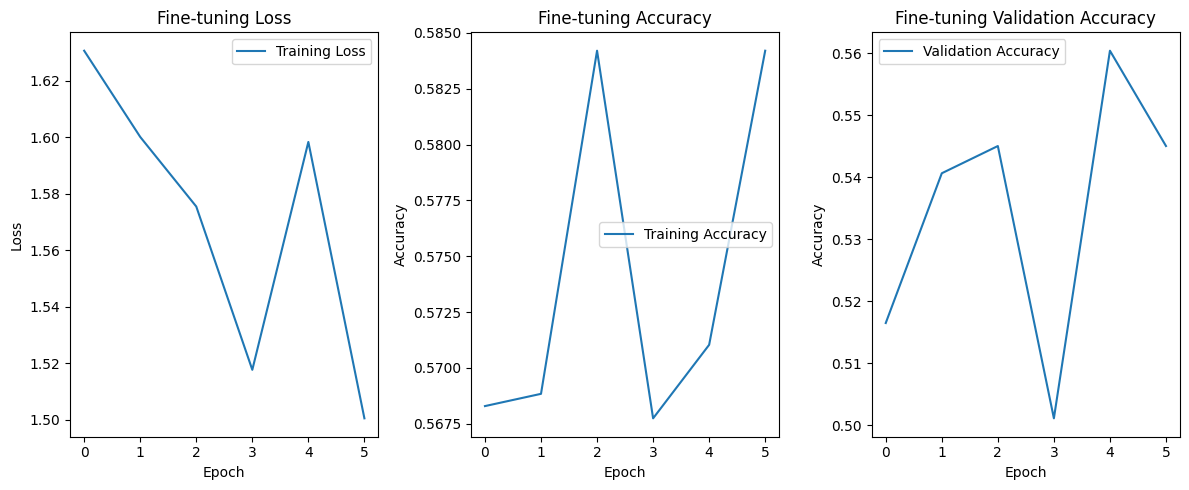

In [170]:
# Plot training loss, accuracy, and validation accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 3, 1)
plt.plot(fine_tune_train_loss_history, label='Training Loss')
plt.title('Fine-tuning Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(fine_tune_accuracy_history, label='Training Accuracy')
plt.title('Fine-tuning Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(fine_tune_val_accuracy_history, label='Validation Accuracy')
plt.title('Fine-tuning Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [171]:
# Print summary
print("\nFine-tuning Summary:")
print(f"Final Fine-tuning Training Loss: {fine_tune_train_loss_history[-1]}")
print(f"Final Fine-tuning Training Accuracy: {fine_tune_accuracy_history[-1]}")

print("\nFine-tuning Validation Summary:")
print(f"Final Fine-tuning Validation Accuracy: {fine_tune_val_accuracy_history[-1]}")


Fine-tuning Summary:
Final Fine-tuning Training Loss: 1.5005755215360408
Final Fine-tuning Training Accuracy: 0.5842018650575974

Fine-tuning Validation Summary:
Final Fine-tuning Validation Accuracy: 0.545054945054945


In [172]:
# Evaluation
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

In [173]:
# Convert to NumPy arrays
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

In [174]:
# Calculate metrics
accuracy = (all_preds == all_labels).mean()
f1 = f1_score(all_labels, all_preds, average='weighted')

In [175]:
# Print metrics
print(f'Test Accuracy: {accuracy}')
print(f'F1 Score: {f1}')

Test Accuracy: 0.5289982425307557
F1 Score: 0.5306612924201782


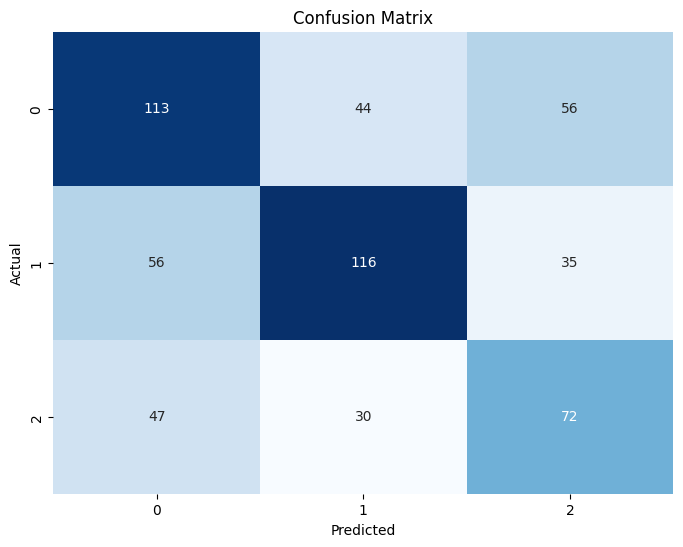

In [176]:
# Get the confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [177]:
from sklearn.metrics import confusion_matrix, classification_report

# Print Classification Report
class_names = [str(i) for i in range(num_classes)]  # Replace with your actual class names
classification_rep = classification_report(all_labels, all_preds, target_names=class_names)
print("Classification Report:\n", classification_rep)

Classification Report:
               precision    recall  f1-score   support

           0       0.52      0.53      0.53       213
           1       0.61      0.56      0.58       207
           2       0.44      0.48      0.46       149

    accuracy                           0.53       569
   macro avg       0.53      0.52      0.52       569
weighted avg       0.53      0.53      0.53       569



In [178]:
!pip install torchviz

In [179]:
# Import library tambahan
from torchviz import make_dot

# Fungsi untuk menyimpan model summary sebagai gambar
def save_model_summary_as_image(model, input_tensor, filename="model_summary.png"):
    # Buat graph dari model menggunakan torchviz
    graph = make_dot(model(input_tensor), params=dict(model.named_parameters()))

    # Simpan grafik sebagai gambar
    graph.render(filename, format='png')

# Visualisasi arsitektur model dan simpan sebagai gambar
input_tensor = torch.randn(1, 3, image_size[0], image_size[1]).to(device)  # Input tensor contoh
save_model_summary_as_image(model, input_tensor)

In [180]:
from torchsummary import summary

input_size = (3, 112, 112)
# Definisikan fungsi untuk mencetak model summary
def print_model_summary(model, input_size):
    summary(model, input_size=input_size, device='cuda')

# Cetak model summary dalam bentuk teks
print_model_summary(model, input_size)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 56, 56]             432
          Identity-2           [-1, 16, 56, 56]               0
         Hardswish-3           [-1, 16, 56, 56]               0
    BatchNormAct2d-4           [-1, 16, 56, 56]              32
            Conv2d-5           [-1, 16, 56, 56]             144
          Identity-6           [-1, 16, 56, 56]               0
              ReLU-7           [-1, 16, 56, 56]               0
    BatchNormAct2d-8           [-1, 16, 56, 56]              32
          Identity-9           [-1, 16, 56, 56]               0
           Conv2d-10           [-1, 16, 56, 56]             256
         Identity-11           [-1, 16, 56, 56]               0
         Identity-12           [-1, 16, 56, 56]               0
   BatchNormAct2d-13           [-1, 16, 56, 56]              32
         Identity-14           [-1, 16,